In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from markowitz.data import ingest, preprocess
from markowitz.simulate import scenarios, efficient_frontier, portfolio_return

### Download the ticker data

In [2]:
exp_ratio = {
    'VBMPX':0.03,
    'VTIFX':0.07,
    'VIIIX':0.02,
    'VSMPX':0.02,
    'VEXRX':0.34,
    'VTPSX':0.07,
    'VGSNX':0.1
}

In [3]:
sd = "2016-01-01"
ed = pd.to_datetime('now').floor('d').strftime('%Y-%m-%d')
tickers = exp_ratio.keys()

data = ingest(tickers, sd, ed)
df = preprocess(data, tickers)

[*********************100%***********************]  7 of 7 completed


In [4]:
print(df.shape)
display(df.head(3))

(1330, 15)


,Date,VBMPX,VTIFX,VIIIX,VSMPX,VEXRX,VTPSX,VGSNX,VBMPX-ret,VTIFX-ret,VIIIX-ret,VSMPX-ret,VEXRX-ret,VTPSX-ret,VGSNX-ret
0,2016-01-04,10.66,31.740000,183.820007,93.790001,73.209999,95.040001,17.260000,0.999062,1.001260,1.002013,1.001813,1.000000,0.998632,1.020278
1,2016-01-05,10.65,31.780001,184.190002,93.959999,73.209999,94.910004,17.610001,1.003756,1.001888,0.987241,0.986696,0.984565,0.985038,0.996593
2,2016-01-06,10.69,31.840000,181.839996,92.709999,72.080002,93.489998,17.549999,1.000935,0.999058,0.976298,0.975731,0.973085,0.980426,0.980627


In [5]:
for c in df.columns:
    if df[c].isnull().sum() == 0:
        print(c, 'all_good')
    else:
        print(c, 'missing_data')

Date all_good
VBMPX all_good
VTIFX all_good
VIIIX all_good
VSMPX all_good
VEXRX all_good
VTPSX all_good
VGSNX all_good
VBMPX-ret all_good
VTIFX-ret all_good
VIIIX-ret all_good
VSMPX-ret all_good
VEXRX-ret all_good
VTPSX-ret all_good
VGSNX-ret all_good


### Simulate and visualize

In [6]:
# 1-year returns for each vehicle across multiple scenarios
# each row is a scenario
rdf = scenarios(df, tickers, exp_ratio, nscenarios=200, ndays=365)
print(rdf.shape)
rdf.head()

(200, 7)


,VBMPX,VTIFX,VIIIX,VSMPX,VEXRX,VTPSX,VGSNX
0,-0.017403,0.009770,0.264333,0.361358,0.375773,0.391116,0.333725
1,-0.020282,-0.019835,0.294673,0.297289,0.150323,0.110923,-0.223027
2,-0.030988,0.039589,0.542049,0.629084,0.555324,0.278024,0.118441
3,-0.000957,-0.017296,0.110193,0.152095,0.118316,-0.005594,-0.069678
4,-0.003075,0.033797,0.501605,0.501158,0.289167,0.171095,0.153324


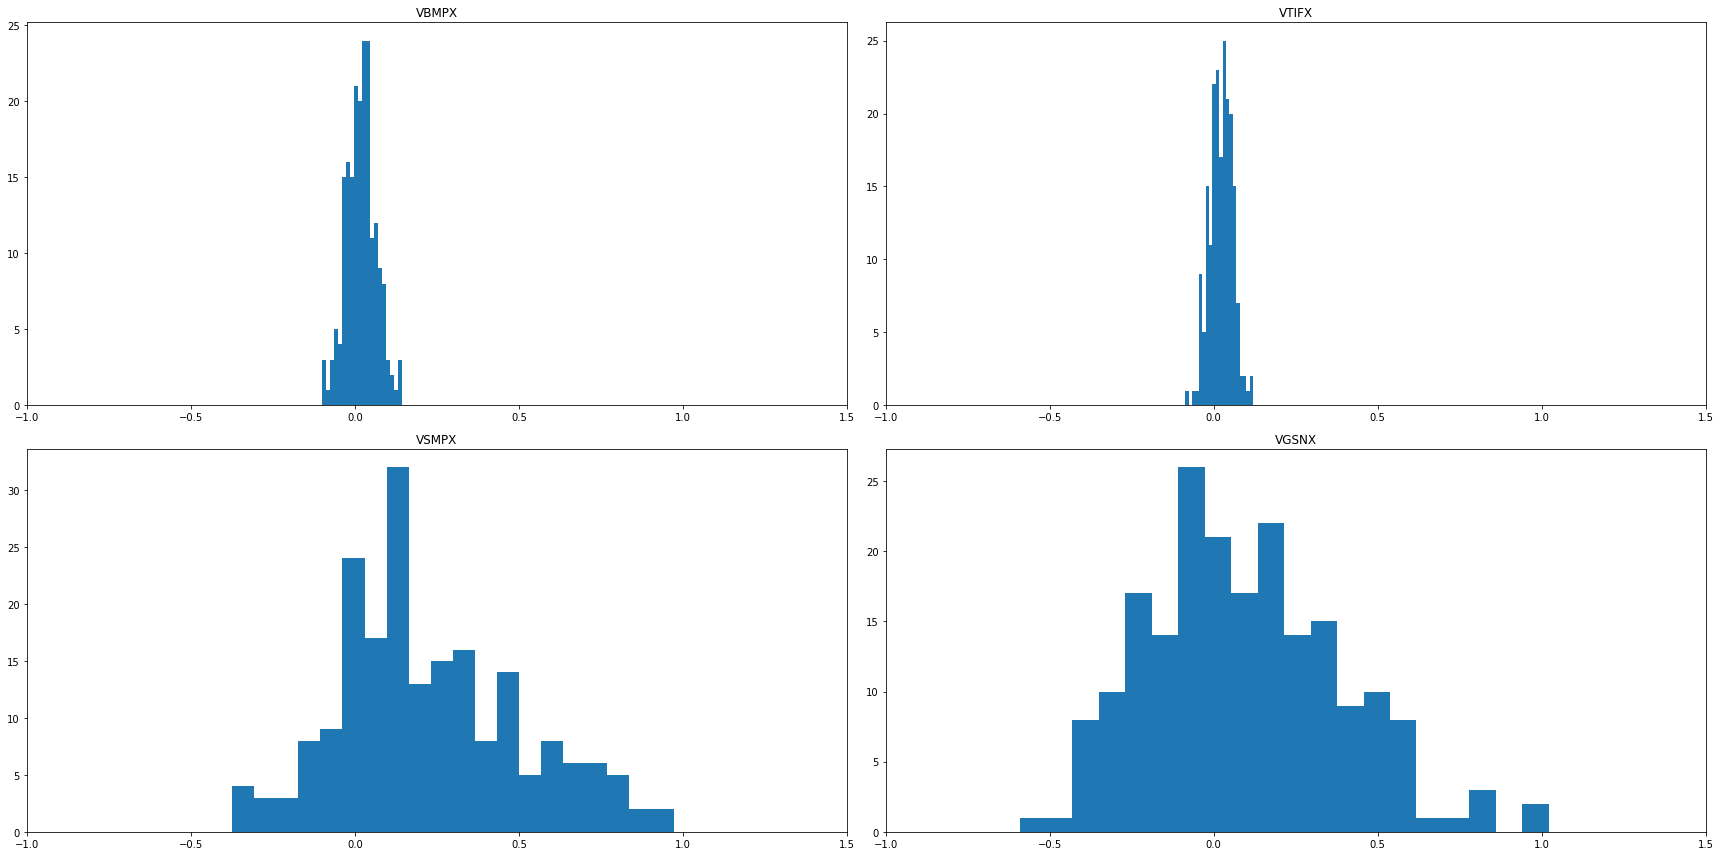

In [7]:
assets = ["VBMPX","VTIFX","VSMPX","VGSNX"]

fig = plt.figure(figsize=(24, 12))
ctr = 0
for i in range(len(assets)):
    plt.subplot(2,2,i+1)
    plt.hist(rdf[assets[i]], bins=20)
    plt.xlim([-1,1.5])
    plt.title(assets[i])

plt.tight_layout()
plt.show()

### Optimize

In [8]:
from markowitz.optimize import optimize

In [9]:
min_ratio = 0.3 # minimum expense ratio
min_assets = 1 # minimum assets in the portfolio
max_risk = [0.05, 0.045, 0.04, 0.035, 0.03, 0.025, 0.02, 0.015, 0.01, 0.005] # max risk of negative returns

res_list = []
for m in max_risk:
    obj, wopt, orisk = optimize(rdf, exp_ratio, m, min_ratio, min_assets)
    wopt.update({'return':obj, 'risk': orisk})
    res_list.append(wopt)

resdf = pd.DataFrame(res_list)

col_list = {}
for i, c in enumerate(rdf.columns):
    col_list[i] = c

resdf = resdf.rename(columns=col_list)
resdf

/Users/anshulagarwal/opt/anaconda3/envs/aag/lib/python3.7/site-packages/pulp/pulp.py:1114: UserWarning: Spaces are not permitted in the name. Converted to '_'
  warnings.warn("Spaces are not permitted in the name. Converted to '_'")


,VBMPX,VTIFX,VIIIX,VSMPX,VEXRX,VTPSX,VGSNX,return,risk
0,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
1,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
2,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
3,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
4,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
5,0.000000,0.000000,0.0,1.000000,0.0,0.0,0.0,22.931395,0.023352
6,0.113066,0.000000,0.0,0.886934,0.0,0.0,0.0,20.546059,0.020000
7,0.142562,0.142780,0.0,0.714658,0.0,0.0,0.0,16.977241,0.015000
8,0.158457,0.315290,0.0,0.526253,0.0,0.0,0.0,13.081842,0.010000
9,0.164248,0.524256,0.0,0.311496,0.0,0.0,0.0,8.647272,0.005000


In [10]:
w = {
    'VBMPX':0.15,
    'VTIFX':0.25,
    'VIIIX':0.0,
    'VSMPX':0.6,
    'VEXRX':0.0,
    'VTPSX':0.0,
    'VGSNX':0.0
}

pdf, perc_neg_scenarios, avg_neg_return, avg_return = portfolio_return(rdf, w)
print(perc_neg_scenarios, avg_neg_return, avg_return)

0.17 -0.011862471253074491 0.14607642989807176


In [11]:
# Final chosen (made a mistake, the fractions got flipped)
res = {
    'VBMPX':0.25,
    'VTIFX':0.15,
    'VSMPX':0.6
}